# Library

At this stage, all the necessary Python libraries are imported for preprocessing.


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from scipy.stats import randint

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Loading Dataset

In [47]:
df = pd.read_csv('../data/bank-full.csv', sep=';')

# Preprocessing

In the preprocessing stage, several key steps are performed to prepare the dataset for machine learning modeling.

In [48]:
df["y"] = df["y"].map({"yes": 1, "no": 0})
X_raw = df.drop("y", axis=1).copy()
y = df["y"].copy()

X_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown


## Handling Missing Values for Numerical and Categorical Features

This code fills missing values based on feature type. Numerical columns are imputed using the median, while categorical columns use the most frequent value (mode).

In [49]:
for col in X_raw.columns:
    if X_raw[col].dtype in ["int64", "float64"]:
        X_raw[col] = X_raw[col].fillna(X_raw[col].median())
    else:
        mode_val = X_raw[col].mode()
        fill_val = mode_val[0] if not mode_val.empty else "unknown"
        X_raw[col] = X_raw[col].fillna(fill_val)

X_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown


## Handling Special Value in pdays Feature

The value 999 in the pdays column indicates that the client was never previously contacted. This code replaces 999 with -1 to make the data more meaningful and easier for models to interpret.

In [50]:
if "pdays" in X_raw.columns:
    X_raw["pdays"] = X_raw["pdays"].replace(999, -1)

X_raw["pdays"].value_counts()

pdays
-1      36954
 182      167
 92       147
 91       126
 183      126
        ...  
 449        1
 452        1
 648        1
 595        1
 530        1
Name: count, Length: 559, dtype: int64

## Outlier Treatment Using the IQR Method

For each numerical feature, outliers are detected using the Interquartile Range (IQR). Values that fall below the lower bound or above the upper bound are capped to the nearest valid boundary. This process reduces extreme variations, stabilizes the feature distribution, and helps improve overall model performance.

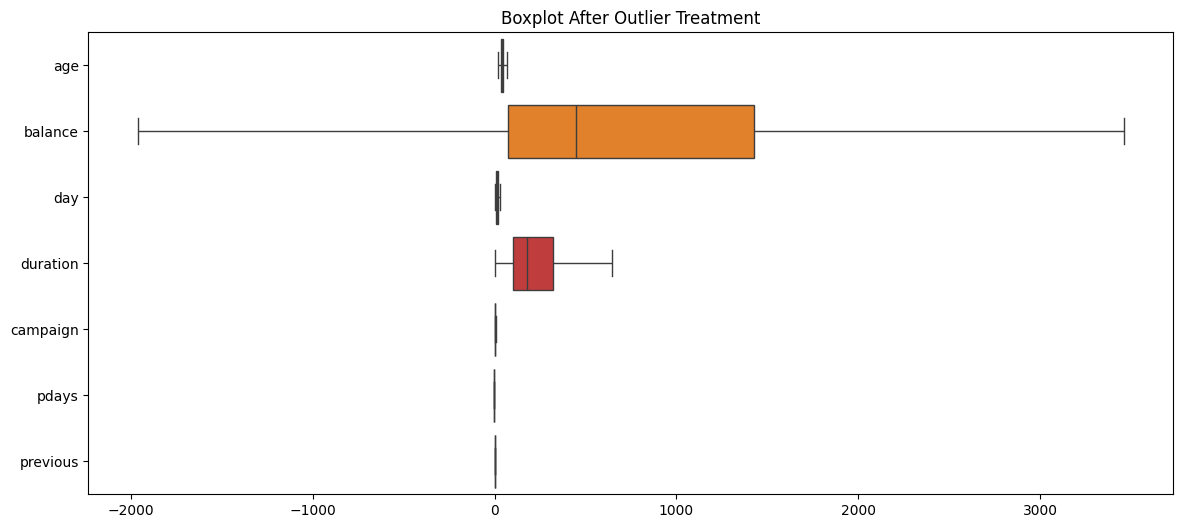

In [51]:
num_cols_raw = X_raw.select_dtypes(include=["int64", "float64"]).columns
for col in num_cols_raw:
    Q1 = X_raw[col].quantile(0.25)
    Q3 = X_raw[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    X_raw[col] = np.where(X_raw[col] < lower, lower,
                 np.where(X_raw[col] > upper, upper, X_raw[col]))

plt.figure(figsize=(14, 6))
sns.boxplot(data=X_raw[num_cols_raw], orient='h')
plt.title("Boxplot After Outlier Treatment")
plt.show()

## Data Splitting

Data splitting is used to separate the dataset into training and testing subsets so the model can learn from one portion while being evaluated on unseen data. This ensures an unbiased assessment of the model’s performance and prevents data leakage.

In [52]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=42
)

## One-Hot Encoding for Categorical Features

Categorical features are transformed using One-Hot Encoding to convert each category into a binary vector. This ensures the model can interpret non-numeric values without introducing ordinal relationships. All encoded columns are combined with the numerical features to form the final processed dataset. The trained encoder is saved as a .pkl file so the same transformation can be applied during inference.

In [53]:
categorical_cols = X_raw.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()

ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ohe.fit(X_train_raw[categorical_cols])

X_train_cat = pd.DataFrame(ohe.transform(X_train_raw[categorical_cols]),
                           columns=ohe.get_feature_names_out(categorical_cols),
                           index=X_train_raw.index)
X_test_cat = pd.DataFrame(ohe.transform(X_test_raw[categorical_cols]),
                          columns=ohe.get_feature_names_out(categorical_cols),
                          index=X_test_raw.index)

X_train_proc = pd.concat([X_train_raw[numerical_cols].reset_index(drop=True),
                          X_train_cat.reset_index(drop=True)], axis=1)
X_test_proc = pd.concat([X_test_raw[numerical_cols].reset_index(drop=True),
                         X_test_cat.reset_index(drop=True)], axis=1)


## Feature Scaling with StandardScaler

A subset of numerical features (age, balance, campaign, pdays, previous, day, duration) is scaled using standardization — subtracting the mean and dividing by the standard deviation. This ensures all features contribute fairly to model training regardless of their original value range. The fitted scaler is saved to scaler.pkl so that the same scaling can be applied during inference, ensuring consistency.

In [54]:
scaler = StandardScaler()
target_scale_cols = ["age", "balance", "campaign", "pdays", "previous", "day", "duration"]
cols_to_scale = [c for c in target_scale_cols if c in X_train_proc.columns]

if cols_to_scale:
    scaler.fit(X_train_proc[cols_to_scale])
    X_train_proc[cols_to_scale] = scaler.transform(X_train_proc[cols_to_scale])
    X_test_proc[cols_to_scale] = scaler.transform(X_test_proc[cols_to_scale])

## Save Encoder and Scaler

In [55]:
joblib.dump(ohe, "../model/onehot_encoder.pkl")
joblib.dump(scaler, "../model/scaler.pkl")

['../model/scaler.pkl']

# Modelling

## Logistic Regression

In [56]:
log_param_grid = {
    'logreg__penalty': ['l2'],
    'logreg__C': [0.1, 1, 5, 10],
    'logreg__solver': ['lbfgs']
}

log_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000))
])

log_grid = GridSearchCV(
    estimator=log_pipeline,
    param_grid=log_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    refit=True
)

log_grid.fit(X_train_proc, y_train)  
print("\nBest Logistic Regression Params:", log_grid.best_params_)
print("Best Logistic Regression CV Score (f1):", log_grid.best_score_)

log_model = log_grid.best_estimator_
print("Tuned Logistic Regression training completed.")


Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Logistic Regression Params: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
Best Logistic Regression CV Score (f1): 0.5388312903545978
Tuned Logistic Regression training completed.


## Random Forest

In [57]:
rf_param_dist = {
    'rf__n_estimators': randint(150, 400),
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': randint(2, 10),
    'rf__min_samples_leaf': randint(1, 5),
    'rf__bootstrap': [True, False]
}

rf_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

rf_random = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=30,
    cv=5,
    scoring='f1',     
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)

rf_random.fit(X_train_proc, y_train)

print("\nBest Random Forest Params:")
print(rf_random.best_params_)
print("\nBest CV Accuracy:", rf_random.best_score_)

rf_model = rf_random.best_estimator_
print("\nTuned Random Forest training completed.")

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Random Forest Params:
{'rf__bootstrap': True, 'rf__max_depth': None, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 3, 'rf__n_estimators': 171}

Best CV Accuracy: 0.5950268633171195

Tuned Random Forest training completed.


## MLP

In [58]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
print("\nClass weight for MLP:", class_weight_dict)

def build_mlp(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

mlp = build_mlp(X_train_proc.shape[1])
early = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = mlp.fit(
    X_train_proc, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early],
    class_weight=class_weight_dict,
    verbose=1
)
print("MLP training completed.")


Class weight for MLP: {0: 0.5662397845758838, 1: 4.27416686362562}
Epoch 1/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7813 - loss: 0.4399 - val_accuracy: 0.8073 - val_loss: 0.3805
Epoch 2/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8031 - loss: 0.3790 - val_accuracy: 0.8084 - val_loss: 0.3771
Epoch 3/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8106 - loss: 0.3667 - val_accuracy: 0.8164 - val_loss: 0.3619
Epoch 4/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8143 - loss: 0.3550 - val_accuracy: 0.7960 - val_loss: 0.3934
Epoch 5/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8208 - loss: 0.3445 - val_accuracy: 0.8079 - val_loss: 0.3759
Epoch 6/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8237 - loss: 0.3391 - val_accuracy: 0.8114 - val_loss: 0.3726
Epoch 7/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8232 - loss: 0.3357 - val_accuracy: 0.8258 - val_loss: 0.3463
Epoch 8/50
1018/1018 ━

# Evaluasi

## Logistic Regression


=== Logistic Regression ===
Training Accuracy : 0.8344
Test Accuracy     : 0.8320
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      7985
           1       0.39      0.82      0.53      1058

    accuracy                           0.83      9043
   macro avg       0.68      0.83      0.72      9043
weighted avg       0.90      0.83      0.85      9043



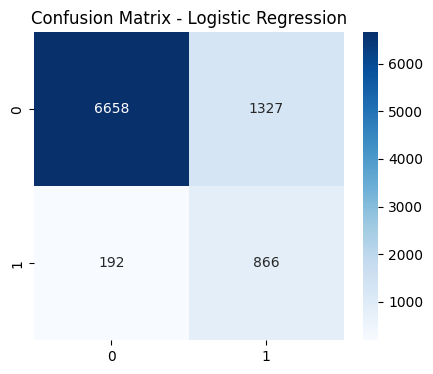

In [59]:
log_train_pred = log_model.predict(X_train_proc)
log_train_acc = accuracy_score(y_train, log_train_pred)

log_pred = log_model.predict(X_test_proc)
log_test_acc = accuracy_score(y_test, log_pred)

print("\n=== Logistic Regression ===")
print(f"Training Accuracy : {log_train_acc:.4f}")
print(f"Test Accuracy     : {log_test_acc:.4f}")
print(classification_report(y_test, log_pred))


plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, log_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Random Forest


=== Random Forest ===
Training Accuracy : 0.9470
Test Accuracy     : 0.8934
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      7985
           1       0.53      0.68      0.60      1058

    accuracy                           0.89      9043
   macro avg       0.75      0.80      0.77      9043
weighted avg       0.91      0.89      0.90      9043



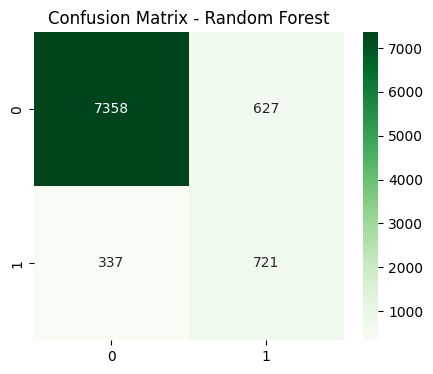

In [60]:
rf_train_pred = rf_model.predict(X_train_proc)
rf_train_acc = accuracy_score(y_train, rf_train_pred)

rf_pred = rf_model.predict(X_test_proc)
rf_test_acc = accuracy_score(y_test, rf_pred)

print("\n=== Random Forest ===")
print(f"Training Accuracy : {rf_train_acc:.4f}")
print(f"Test Accuracy     : {rf_test_acc:.4f}")
print(classification_report(y_test, rf_pred))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.show()

## MLP (Deep Learning)

1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step

=== Deep Learning (MLP) ===
Training Accuracy : 0.8339
Test Accuracy     : 0.8243
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      7985
           1       0.39      0.90      0.54      1058

    accuracy                           0.82      9043
   macro avg       0.69      0.86      0.72      9043
weighted avg       0.91      0.82      0.85      9043



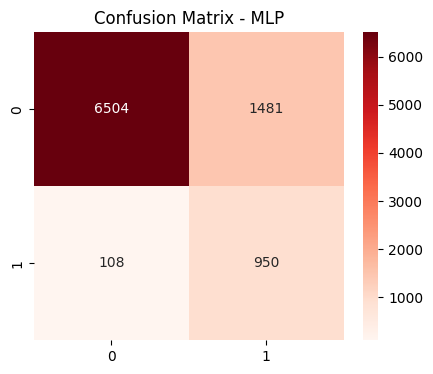

In [61]:
y_train_probs = mlp.predict(X_train_proc).flatten()
y_train_dl = (y_train_probs > 0.5).astype(int)
dl_train_acc = accuracy_score(y_train, y_train_dl)

y_pred_probs = mlp.predict(X_test_proc).flatten()
y_pred_dl = (y_pred_probs > 0.5).astype(int)
dl_test_acc = accuracy_score(y_test, y_pred_dl)

print("\n=== Deep Learning (MLP) ===")
print(f"Training Accuracy : {dl_train_acc:.4f}")
print(f"Test Accuracy     : {dl_test_acc:.4f}")
print(classification_report(y_test, y_pred_dl))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_dl), annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix - MLP")
plt.show()

## Best Model

In [62]:
print("  MODEL COMPARISON ACCURACY")
print(f"Logistic Regression : Train={log_train_acc:.4f} | Test={log_test_acc:.4f}")
print(f"Random Forest       : Train={rf_train_acc:.4f} | Test={rf_test_acc:.4f}")
print(f"Deep Learning (MLP) : Train={dl_train_acc:.4f} | Test={dl_test_acc:.4f}")

acc_log = log_test_acc
acc_rf = rf_test_acc
acc_dl = dl_test_acc

best_model_name = max(
    [("logistic", acc_log), ("random_forest", acc_rf), ("deep_learning", acc_dl)],
    key=lambda x: x[1]
)[0]

print("\nBEST MODEL:", best_model_name.upper())


  MODEL COMPARISON ACCURACY
Logistic Regression : Train=0.8344 | Test=0.8320
Random Forest       : Train=0.9470 | Test=0.8934
Deep Learning (MLP) : Train=0.8339 | Test=0.8243

BEST MODEL: RANDOM_FOREST


## Cross Validation

In [63]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_cv_scores = cross_val_score(log_pipeline, X_train_proc, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
rf_cv_scores = cross_val_score(rf_pipeline, X_train_proc, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)

print("\nCROSS VALIDATION (train set):")
print("Logistic CV Accuracy:", log_cv_scores, "Mean:", np.mean(log_cv_scores))
print("RF CV Accuracy     :", rf_cv_scores, "Mean:", np.mean(rf_cv_scores))


CROSS VALIDATION (train set):
Logistic CV Accuracy: [0.83370196 0.83480785 0.83287255 0.83782663 0.82870178] Mean: 0.8335821545040488
RF CV Accuracy     : [0.88816699 0.89867293 0.89839646 0.90114752 0.89769114] Mean: 0.8968150079805408


# Lead Scoring

In [64]:
if best_model_name == "deep_learning":
    best_clf = mlp
    probs = best_clf.predict(X_test_proc).flatten()

elif best_model_name == "logistic":
    best_clf = log_model
    probs = best_clf.predict_proba(X_test_proc)[:, 1]

elif best_model_name == "random_forest":
    best_clf = rf_model
    probs = best_clf.predict_proba(X_test_proc)[:, 1]

lead_score = (probs * 100).astype(int)

def categorize(score):
    if score >= 70:  return "HIGH PRIORITY"
    if score >= 40:  return "MEDIUM PRIORITY"
    return "LOW PRIORITY"

priority = [categorize(s) for s in lead_score]

final_sales_view = X_test_raw.copy() 
final_sales_view["Actual_Label"] = y_test.values
final_sales_view["Probability"] = probs
final_sales_view["Lead Score"] = lead_score
final_sales_view["Lead Priority"] = priority

final_sales_view = final_sales_view.sort_values("Lead Score", ascending=False)

print("\nTop 20 Hot Leads:")
display(final_sales_view.head(20))



Top 20 Hot Leads:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Actual_Label,Probability,Lead Score,Lead Priority
43122,20.0,student,single,secondary,no,215.0,no,no,cellular,24.0,feb,175.0,1.0,-1.0,0.0,success,1,0.987752,98,HIGH PRIORITY
43005,60.0,retired,married,secondary,no,523.0,no,no,cellular,11.0,feb,467.0,1.0,-1.0,0.0,success,1,0.974841,97,HIGH PRIORITY
43705,68.0,retired,married,secondary,no,1146.0,no,no,cellular,13.0,may,356.0,1.0,-1.0,0.0,success,1,0.968112,96,HIGH PRIORITY
43135,25.0,student,single,secondary,no,469.0,no,no,cellular,24.0,feb,524.0,1.0,-1.0,0.0,success,0,0.969727,96,HIGH PRIORITY
43033,48.0,unemployed,married,secondary,no,926.0,no,no,cellular,15.0,feb,382.0,4.0,-1.0,0.0,success,1,0.962655,96,HIGH PRIORITY
44401,62.0,retired,married,secondary,no,569.0,no,no,cellular,4.0,aug,288.0,1.0,-1.0,0.0,success,1,0.950069,95,HIGH PRIORITY
43731,70.5,retired,married,secondary,no,3462.0,no,no,cellular,17.0,may,643.0,1.0,-1.0,0.0,success,1,0.954133,95,HIGH PRIORITY
43479,51.0,management,married,tertiary,no,469.0,no,no,cellular,15.0,apr,200.0,1.0,-1.0,0.0,success,1,0.952670,95,HIGH PRIORITY
43336,31.0,management,single,tertiary,no,3384.0,no,no,cellular,22.0,mar,247.0,3.0,-1.0,0.0,success,1,0.953983,95,HIGH PRIORITY
44027,30.0,student,single,secondary,no,314.0,no,no,cellular,29.0,jun,189.0,1.0,-1.0,0.0,success,0,0.954490,95,HIGH PRIORITY


# Menyimpan Model

In [65]:
joblib.dump(log_model, "../model/logreg.pkl")
joblib.dump(rf_model, "../model/random_forest.pkl")
mlp.save("../model/mlp.keras")

if best_model_name == "deep_learning":
    mlp.save("../model/BEST_MODEL.h5")
    print("\nBest Model saved as BEST_MODEL.h5 (Deep Learning)")

elif best_model_name == "logistic":
    joblib.dump(log_model, "../model/BEST_MODEL.pkl")
    print("\nBest Model saved as BEST_MODEL.pkl (Logistic Regression)")

elif best_model_name == "random_forest":
    joblib.dump(rf_model, "../model/BEST_MODEL.pkl")
    print("\nBest Model saved as BEST_MODEL.pkl (Random Forest)")

print("\nAll models saved successfully!")


Best Model saved as BEST_MODEL.pkl (Random Forest)

All models saved successfully!
